# 初始化

In [1]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

%config InlineBackend.figure_format = 'retina'

import progressbar

# import mosek
# import pickle
# import math

# import os


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [3]:
# # cost extremely long time, like one minute
# import run_sim

# 读data，求lambda

Text(0.5, 0, '20011014.csv')

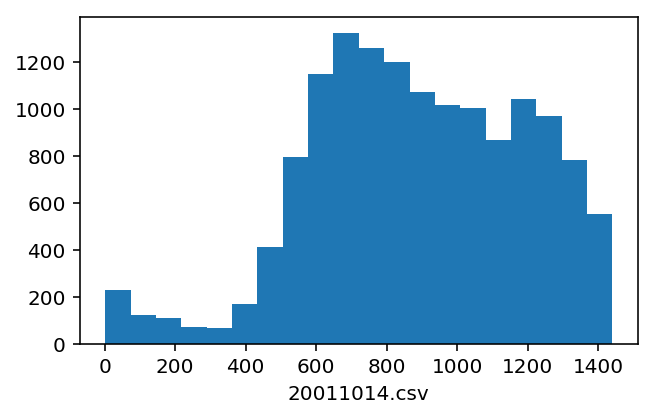

In [20]:
path = '/Users/shuffle/Desktop/GAN/Code/data/'
file = '20011014.csv'

data_2 = pd.read_csv(path+file)
data_2['start_datetime'] = pd.to_datetime(data_2['start_datetime'])
data_2.sort_values('start_datetime',inplace=True)
start_datetime = data_2.start_datetime.values
# 单位是分钟，minute of day
start_datetime = ((start_datetime - np.datetime64('2001-10-14')).astype(float)/1e9/60).astype(float)
n_arrival = len(data_2)
plt.figure(figsize=(5,3))
none = plt.hist(start_datetime,bins=20)
plt.xlabel(file)

In [52]:
# Read your data here.

# Units of arrival time should be converted to miniute, if not. Range of arrival time should be 0~1440, since there's 1440 minutes totally in one day.
arrival_time_min = start_datetime
# arrival_time_min = #Read your data here#

Text(0, 0.5, 'Number of arrivals each hour')

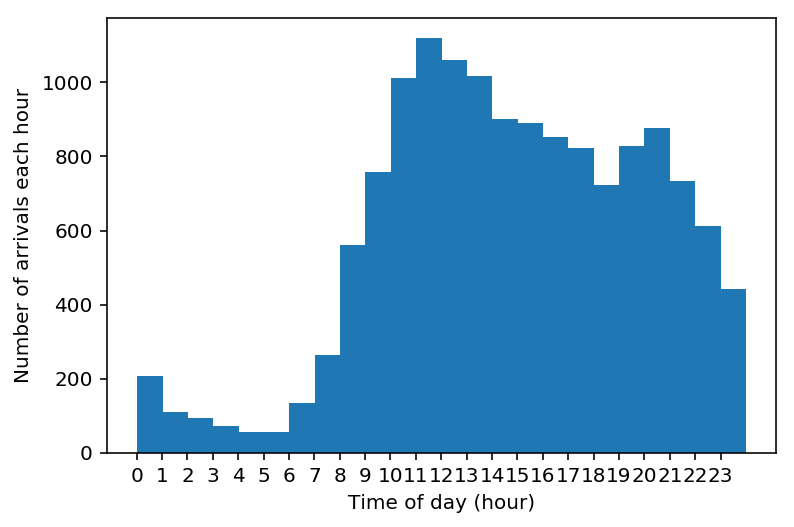

In [44]:
# Get a overview of arrival data.

plt.hist(arrival_time_min,bins=24)
none = plt.xticks(np.arange(0,1440,60),np.arange(24))
plt.xlabel('Time of day (hour)')
plt.ylabel('Number of arrivals each hour')

# 求 $\lambda$

According to the assumption, whether we are using piecewise linear density (PL) or piecewise constant density (PC) to model the arrival data, we need to specify the time nodes to divide the whole day into several time intervals. And inside each time interval, density function shares the same expression (has same slope and intercept for PL, and same value for PC).

For example, if we set time nodes as 0 min, 180 min, 540 min and 1440 min, which means we divide the whole day into these period: \[0,180\], \[180, 540\], \[540, 1440\]. Then for PL density function, we need a total of four parameters to fit the arrival process, i.e., the density at time 0 min, 180 min, 540 min and 1440 min. For PC density function, we need three parameters to determine the model, i.e., the constant density of each period.


In [50]:
# Specify the time nodes.

# If time intervals are divided equally, you can use the following code.

# period_length: length of each interval in minutes.
'''
period_length = 120
interval = np.arange(0,1440+1,period_length) 
'''

# Or you can also set time nodes manually. Do set 0 as the first element of the list, and 1440 as the last element of the list.
interval = [0, 180, 540, 1440]


## Piecewise Linear (PL)

In [48]:
# n_para: number of parameters to be determined
n_para = len(interval)

Suppose we have a sample of size $n, \pi=\left\{x_{1}, x_{2} \ldots x_{n}\right\}$ from a Poisson process.

Let $\lambda$ the intensity function be, $\lambda:[0, T] \rightarrow \mathbb{R} \geq 0$

$\Lambda=\int_{0}^{T} \lambda(x) d x$

Probability of observing n points $=e^{-\Lambda} \frac{\Lambda^{n}}{n !}$

Probability density of observation $x_{i}=\frac{\lambda\left(x_{i}\right)}{\Lambda}$

$L(\lambda)=e^{-\Lambda} \cdot \prod_{i=1}^{n} \lambda\left(x_{i}\right)=e^{-\int_{0}^{T} \lambda(x) d x} \cdot \prod_{i=1}^{n} \lambda\left(x_{i}\right)$

The Log-Likelihood: $l(\lambda)=\log (L(\lambda))=-\int_{0}^{T} \lambda(x) d x+\sum_{i=1}^{n} \log \lambda\left(x_{i}\right)$



In [53]:
# Construct the problem.

# lam: decision variables, i.e., density at the time nodes we set.
lam = cp.Variable(n_para)

# integral: integral of density function over the whole day.
integral = 0
for i in range(n_para - 1):
    int_start = interval[i]
    int_end = interval[i+1]
    len_int = int_end - int_start
    integral += (lam[i]+lam[i+1])*len_int/2

In [58]:
# obj_func_log: DataFrame to store all the information for each arrival.
# arrival_time_min: arrival time of the arrival in minutes.
# interval_index: denotes the interval index that the arrival belongs to. Interval index start from 0, and grows by 1.
# log_lam: suppose the arrival time is t, log_lam is log(\lambda(t)), where \lambda(t) is the density at time t.
obj_func_log = pd.DataFrame(columns=['arrival_time_min','interval_index','log_lam'])
obj_func_log['arrival_time_min'] = arrival_time_min

# summation of log(\lambda(t)) over all arrivals.
sum_log = 0

for i in range(n_para - 1):
    print('now we run to '+str(i)+'-th interval')
    int_start = interval[i]
    int_end = interval[i+1]
    
    lam_start = lam[i]
    lam_end = lam[i+1]
    
    obj_func_log.loc[(arrival_time_min <= int_end) & (arrival_time_min > int_start),'interval_index'] = i

    int_slope = (lam_end-lam_start)/(int_end-int_start)
    obj_func_log.loc[(arrival_time_min <= int_end) & (arrival_time_min > int_start),'log_lam'] = \
        obj_func_log.loc[(arrival_time_min <= int_end) & (arrival_time_min > int_start)].arrival_time_min.\
        apply(lambda t:  cp.log( int_slope*(t-int_start) + lam_start))

sum_log = cp.sum(cp.hstack(obj_func_log['log_lam'].values))

objective = cp.Maximize(- integral + sum_log)
constraints = [lam >= 0]
prob = cp.Problem(objective, constraints)

now we run to 0-th interval
now we run to 1-th interval
now we run to 2-th interval


In [59]:
# Solve the problem. 
# You can specify another solver, or use cvxpy's default solver by simply set 'solver=None'.
# Default is strongly not encouraged because it can be extremely slow and unstable.
# Solving an arrival process with total number of arrivals around 15,000 using Mosek usually takes 3 minutes on a 2015 Macbook Pro. Be patient.
result = prob.solve(solver=cp.MOSEK)

## 分段常数

In [909]:
# 以分钟为单位的时间段划分，包括0和1440
# interval = np.array([0,400,600,800,1000,1440])

n_interval = len(interval) - 1

In [910]:
# 以区间的起点，记录每个区间的 intensity
lam_value_const = np.zeros(n_interval)
for i in range(n_interval):
    interval_start = interval[i]
    interval_end = interval[i+1]
    len_interval = interval_end - interval_start
    intensity = np.sum((start_datetime < interval_end) * (start_datetime >= interval_start))/len_interval
    lam_value_const[i] = intensity

In [911]:
MLL_result = {'interval':interval,
              'lam_value_piecewise':lam.value,
              'lam_value_const':lam_value_const,
              'start_datetime':start_datetime}


with open('main result/MLL_result.pickle', 'wb') as f:
    pickle.dump(MLL_result, f)

# 读结果，画图

In [912]:
# 单位 分钟

with open('main result/MLL_result.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    MLL_result = pickle.load(f)

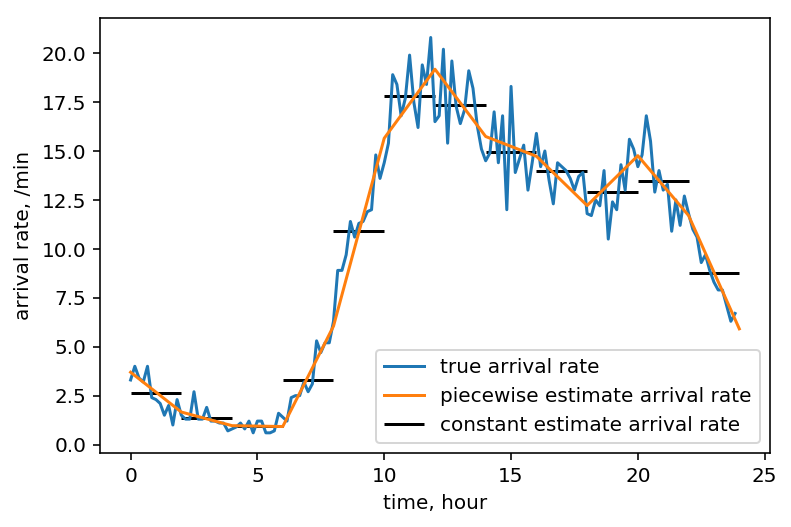

In [913]:
interval = np.array(MLL_result['interval'])  
n_interval = len(interval) - 1
interval_length = (max(MLL_result['interval'])-min(MLL_result['interval']))


# 统计real data平均每分钟到了多少
# 用来求平均的一段是多少，单位是分钟
tw = 10
hist_bins = np.arange(0,24*60+1,tw)
hist_num = np.histogram(MLL_result['start_datetime'],bins=hist_bins)[0]/tw


# none = plt.hist(start_datetime,bins=100)
plt.plot(hist_bins[:-1]/60,hist_num)
plt.plot(interval/60,MLL_result['lam_value_piecewise'])
# plt.scatter(interval/60,MLL_result['lam_value_piecewise'])

for i in range(n_interval):
    interval_start = interval[i]/60
    interval_end = interval[i+1]/60
    plt.hlines(xmin=interval_start,xmax=interval_end,y=MLL_result['lam_value_const'][i])
    
    
plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise estimate arrival rate','constant estimate arrival rate'])

# 根据估计的arrival rate，生成新的arrival series

## piecewise intensity

### inversion

In [914]:
# 会用到的函数

# 时间单位 统一为 小时
vexp = np.vectorize(math.exp)

In [915]:
# input var: interval_hour, lam, n_interval
# 从 “读数据 画图”里读数据
interval_hour = interval/60
lam = MLL_result['lam_value_piecewise']*60
n_interval = len(interval_hour) - 1

In [916]:
print('从 piecewise linear intensity 通过 inversion的方法生成数据')
print('n_exper: 试验次数，interval_hour: 小时为单位的interval断点，lam：小时为单位的intensity')
def GenerateFromPW(n_exper,interval_hour,lam):
    # lam = np.array([1,16,16,4])
    # interval_hour = np.array([0,1.5,2.5,4.5])
    # n_interval = len(lam) - 1


    # interval_hour 的符号化计法
    t_k = interval_hour
    # 每段interval的长度
    l_k = interval_hour[1:] - interval_hour[:-1]
    # 每段interval的斜率
    a_k = (lam[1:] - lam[:-1])/l_k
    # 每段interval的截距离
    b_k = lam[:-1] - a_k * interval_hour[:-1]

    t_max = max(interval_hour)

    u_j = np.zeros(n_interval)
    for j in range(n_interval):
        u_j[j] = 1 - math.exp(-(a_k[j]/2)*(t_k[j+1]**2-t_k[j]**2) - b_k[j]*(t_k[j+1]-t_k[j]))


    # 计算平均下来有多少个到达，用来提前分配内存
    E_n_arrival = 0
    for i in range(n_interval):
        interval_start = t_k[i]
        interval_end = t_k[i+1]
        lam_start = lam[i]
        lam_end = lam[i+1]
        E_n_arrival += (lam_start+lam_end)*(interval_end-interval_start)/2
        
    
    
    T_list_mat = np.ones((n_exper, 2*int(E_n_arrival)))*-1
    # T_list_mat = np.ones(2*int(E_n_arrival))*-1



    # np.random.seed(0)
    print_T_i = False
    print_k = False

    with progressbar.ProgressBar(max_value=n_exper) as bar:

        for i in range(n_exper):

            bar.update(i)

            t_i_1 = 0
            last_arrival = t_i_1
            k = 0

            T_list_mat[i,0] = t_i_1
            # 判断是否已经到了最后一个period，如果再生成一个就超过最后一个period的话，break_flag的数值改为True，结束循环
            not_break = True

            # 表示下一个事件的id，从1开始，因为0这个位置被最开始的 t_i_1 的数值占了
            arrival_id = 1

            while (t_i_1 < t_max) & not_break:

                ##### Step 1. Obtain u as a sample from Uniform(0,1).
                u = np.random.rand()

                ##### Step 2. Assuming t_i_1 occurs in interval k, compute
                try:
                    u_k = 1 - math.exp(-(a_k[k]/2) * (t_k[k+1]**2-t_i_1**2)-b_k[k] * (t_k[k+1]-t_i_1))
                except:
                    u_k = 1
                while u > u_k:
                    ##### Step 4. If u > u_k, 改变几个变量的值
                    u = (u-u_k)/(1-u_k)
                    t_i_1 = t_k[k+1]
                    k += 1
                    if print_k:
                        print(k)
                    if k == n_interval:
                        not_break = False
                        break
                    # go to step 3 using u_k from whole line segments
                    u_k = u_j[k]
                else:
                    ##### Step 3. If u <= u_k, 则 计算 T_i（下一个事件发生的时刻），生成一个事件
                    if a_k[k] != 0: ##########
                        T_i = (-b_k[k]+\
                                math.sqrt(b_k[k]**2 + a_k[k]**2*t_i_1**2 + 2*a_k[k]*b_k[k]*t_i_1 - 2*a_k[k]*math.log(1-u)))/a_k[k]
                    else:
                        T_i = t_i_1 - math.log(1-u)/b_k[k]     
                interarrival = T_i - last_arrival
                t_i_1 = T_i
                last_arrival = t_i_1
                if not_break & print_T_i:
                    print('T_i =',T_i) 
                T_list_mat[i,arrival_id] = T_i
                arrival_id += 1  

    #         print(i)
    
    return T_list_mat

从 piecewise linear intensity 通过 inversion的方法生成数据
n_exper: 试验次数，interval_hour: 小时为单位的interval断点，lam：小时为单位的intensity


In [917]:
n_exper = 100
T_list_mat_pw = GenerateFromPW(n_exper,interval_hour,lam)

100% (100 of 100) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


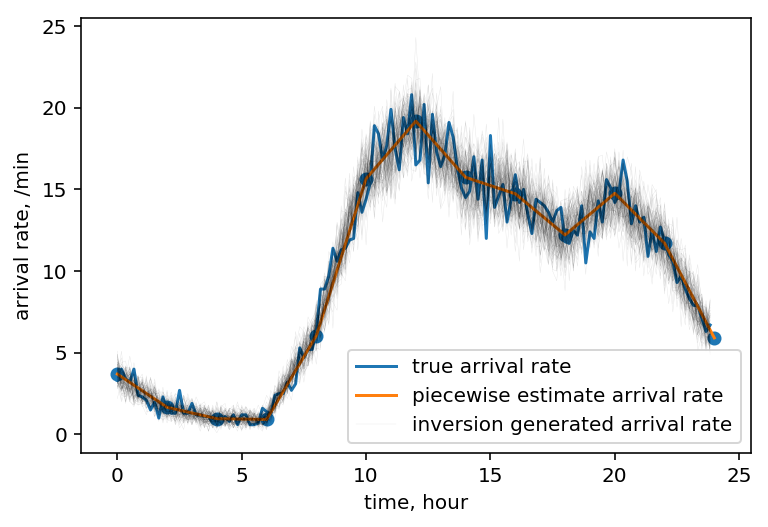

In [918]:
interval = np.array(MLL_result['interval'])  
interval_length = (max(MLL_result['interval'])-min(MLL_result['interval']))


###### true arrival rate
# 统计real data平均每分钟到了多少
# 用来求平均的一段是多少，单位是分钟
tw = 10
true_hist_bins = np.arange(0,24*60+1,tw)
true_hist_num = np.histogram(MLL_result['start_datetime'],bins=true_hist_bins)[0]/tw
plt.plot(hist_bins[:-1]/60,hist_num)


############## estimate arrival rate
plt.plot(interval/60,MLL_result['lam_value_piecewise'])
plt.scatter(interval/60,MLL_result['lam_value_piecewise'])


############# generated arrival rate
for i in range(n_exper):
    T_i_list = T_list_mat_pw[i,:]
    T_i_list = T_i_list[T_i_list > -1]
    T_i_list_hour = T_i_list*60
    generated_hist_bins = np.arange(0,24*60+1,tw)
    generated_hist_num = np.histogram(T_i_list_hour,bins=generated_hist_bins)[0]/tw
    plt.plot(hist_bins[:-1]/60,generated_hist_num,c='k',alpha=0.1,lw=0.2)



plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise estimate arrival rate','inversion generated arrival rate'])

### thinning （还没改成同时生成多个的）

In [415]:
# input var: interval_hour, lam, n_interval
# 从 “读数据 画图”里读数据
interval_hour = interval/60
lam = MLL_result['lam_value']*60
n_interval = len(interval_hour) - 1

KeyError: 'lam_value'

In [95]:
t_max = max(interval_hour)

In [96]:
max_lam = max(lam)
# 没有 thinning 之前，以 max_lam 的速率生成 t_max 这么长时间的 poisson process 大概会有多少个
E_fat_n_arrival = max_lam * t_max
# 1.5 是用来保证生成数据足够的
fat_interval = np.random.exponential(1/max_lam, int(1.5*E_fat_n_arrival))
fat_arrival_time = np.cumsum(fat_interval)
fat_arrival_time = fat_arrival_time[fat_arrival_time <= 24]
n_fat_arrival = len(fat_arrival_time)
fat_uniform = np.random.rand(n_fat_arrival)

In [98]:
fat_df = pd.DataFrame(columns=['fat_arrival_time','interval_index','accept_prob','uniform_rv','whether_accept'])
fat_df.fat_arrival_time = fat_arrival_time
fat_df['uniform_rv'] = fat_uniform

for i in range(n_interval):
#     print(i)
    int_start = interval_hour[i]
    int_end = interval_hour[i+1]

    lam_start = lam[i]
    lam_end = lam[i+1]
    
#     print(int_start)
    
    fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start),'interval_index'] = i
    
    int_slope = (lam_end-lam_start)/(int_end-int_start)
    fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start),'accept_prob'] = \
        fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start)].fat_arrival_time.\
        apply(lambda t:  int_slope*(t-int_start) + lam_start)/max_lam

#     int_slope = (lam_end-lam_start)/(int_end-int_start)
#     obj_func_log.loc[(start_datetime <= int_end) & (start_datetime > int_start),'log_lam'] = \
#         obj_func_log.loc[(start_datetime <= int_end) & (start_datetime > int_start)].start_datetime.\
#         apply(lambda t:  cp.log( int_slope*(t-int_start) + lam_start))

fat_df['whether_accept'] = fat_df['uniform_rv'] <= fat_df['accept_prob']

In [99]:
thinning_df = fat_df[fat_df['whether_accept']]
thin_T_i_list = thinning_df.fat_arrival_time.values

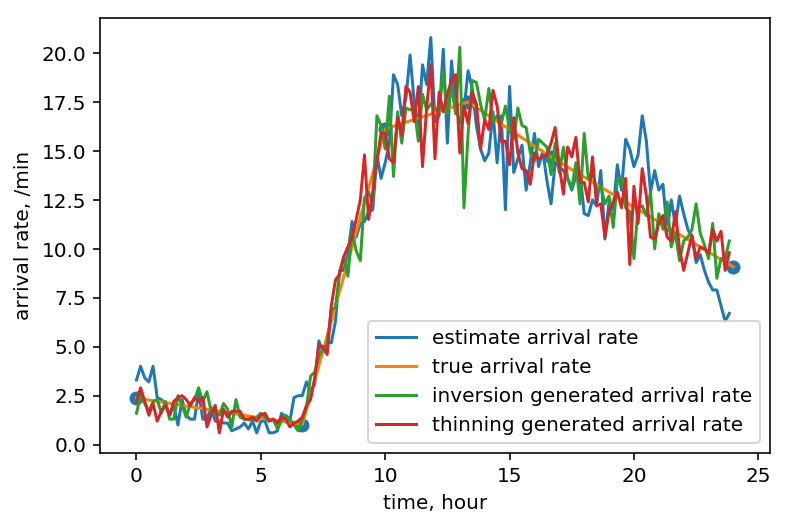

In [100]:
interval = np.array(MLL_result['interval'])  
interval_length = (max(MLL_result['interval'])-min(MLL_result['interval']))


###### true arrival rate
# 统计real data平均每分钟到了多少
# 用来求平均的一段是多少，单位是分钟
tw = 10
true_hist_bins = np.arange(0,24*60+1,tw)
true_hist_num = np.histogram(MLL_result['start_datetime'],bins=true_hist_bins)[0]/tw
plt.plot(hist_bins[:-1]/60,hist_num)


############## estimate arrival rate
plt.plot(interval/60,MLL_result['lam_value'])
plt.scatter(interval/60,MLL_result['lam_value'])


############# inversion generated arrival rate
T_i_list_hour = T_i_list*60
inversion_hist_bins = np.arange(0,24*60+1,tw)
inversion_hist_num = np.histogram(T_i_list_hour,bins=inversion_hist_bins)[0]/tw
plt.plot(inversion_hist_bins[:-1]/60,generated_hist_num)


# ############# thinning generated arrival rate
thinning_hist_bins = np.arange(0,24*60+1,tw)
thinning_hist_num = np.histogram(thin_T_i_list*60,bins=generated_hist_bins)[0]/tw
plt.plot(thinning_hist_bins[:-1]/60,thinning_hist_num)






plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['estimate arrival rate','true arrival rate','inversion generated arrival rate','thinning generated arrival rate'])




## constant intensity

In [919]:
def GenerateFromCON(n_exper,interval_hour,lam):
    E_n_arrival = 0
    for i in range(n_interval):
        interval_start = interval_hour[i]
        interval_end = interval_hour[i+1]
        E_n_arrival += 60*lam[i]*(interval_end-interval_start)

    T_list_mat = np.ones((n_exper, 2*int(E_n_arrival)))*-1

    for i in range(n_exper):
    #     print(i)
        flag = 0
        for j in range(n_interval):
            interval_start = interval_hour[j]
            interval_end = interval_hour[j+1]
            E_n_arrival_within_interval = 60*lam[j]*(interval_end-interval_start)
            n_arrival_within_interval = np.random.poisson(E_n_arrival_within_interval)
            arrival_time_within_interval = np.sort(np.random.uniform(low=interval_start, high=interval_end, size=n_arrival_within_interval))
            T_list_mat[i,flag:flag+n_arrival_within_interval] = arrival_time_within_interval
            flag += n_arrival_within_interval

    return T_list_mat

In [920]:
n_exper = 100
interval_hour = MLL_result['interval']/60
lam = MLL_result['lam_value_const']
T_list_mat_const = GenerateFromCON(n_exper,interval_hour,lam)

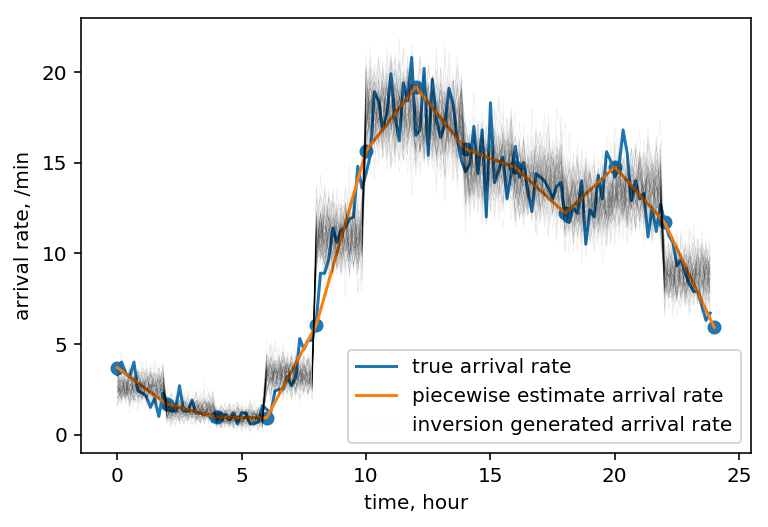

In [921]:
interval = np.array(MLL_result['interval'])  
interval_length = (max(MLL_result['interval'])-min(MLL_result['interval']))


###### true arrival rate
# 统计real data平均每分钟到了多少
# 用来求平均的一段是多少，单位是分钟
tw = 10
true_hist_bins = np.arange(0,24*60+1,tw)
true_hist_num = np.histogram(MLL_result['start_datetime'],bins=true_hist_bins)[0]/tw
plt.plot(hist_bins[:-1]/60,hist_num)


############## estimate arrival rate
plt.plot(interval/60,MLL_result['lam_value_piecewise'])
plt.scatter(interval/60,MLL_result['lam_value_piecewise'])


############# generated arrival rate
for i in range(n_exper):
    T_i_list = T_list_mat_const[i,:]
    T_i_list = T_i_list[T_i_list > -1]
    T_i_list_hour = T_i_list*60
    generated_hist_bins = np.arange(0,24*60+1,tw)
    generated_hist_num = np.histogram(T_i_list_hour,bins=generated_hist_bins)[0]/tw
    plt.plot(hist_bins[:-1]/60,generated_hist_num,c='k',alpha=0.1,lw=0.2)



plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise estimate arrival rate','inversion generated arrival rate'])

# 跑仿真

## get number of server

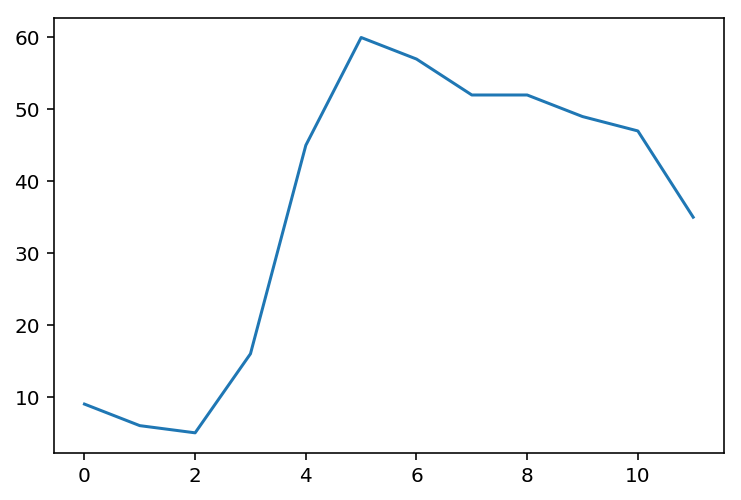

In [922]:
arrival_time_ori_sec = (MLL_result['start_datetime']*60).astype(int)
serve_time_ori_sec = data_2.work_time.values
wait_time_ori_sec = data_2.wait_time.values
period_length_sec = period_length * 60
print_flag = False
num_server = run_sim.GetNServer(arrival_time_ori_sec, serve_time_ori_sec, wait_time_ori_sec, period_length_sec, print_flag)
num_server = (np.array(num_server)*0.9).astype(int)
plt.plot(num_server)

In [924]:
# 顺便整理出来，原始数据中 根据每个时段 对serve time做一个切割
serve_time_each_interval = {}

for j in range(n_interval):
    interval_start_sec = interval[j]*60
    interval_end_sec = interval[j+1]*60
    index_arrival_within_interval = (arrival_time_ori_sec>=interval_start_sec)*(arrival_time_ori_sec<interval_end_sec)
    serve_time_sec_within_interval = serve_time_ori_sec[index_arrival_within_interval]
    serve_time_each_interval[j] = serve_time_sec_within_interval

## run through queue

In [925]:
wait_time_const = np.ones(np.shape(T_list_mat_const))*-1

with progressbar.ProgressBar(max_value=n_exper) as bar:
    for i in range(n_exper):

        arrival_time_sec = (T_list_mat_const[i,:]*3600).astype(int)
        arrival_time_sec = arrival_time_sec[arrival_time_sec > 0]

        n_arrival = len(arrival_time_sec)
        # 生成 serve_time
        serve_time_sec = np.zeros(len(arrival_time_sec),dtype=int)
        flag = 0
        for j in range(n_interval):
            interval_start_sec = interval[j]*60
            interval_end_sec = interval[j+1]*60
            n_arrival_within_interval = np.sum((arrival_time_sec>=interval_start_sec)*(arrival_time_sec<interval_end_sec))
        #     print(n_arrival_within_interval)
            serve_time_sec[flag:flag+n_arrival_within_interval] = np.random.choice(serve_time_each_interval[j], n_arrival_within_interval)
            flag += n_arrival_within_interval


        wait_time_const[i,:n_arrival] = run_sim.RunSim(num_server, arrival_time_sec, serve_time_sec, period_length_sec)
        
        bar.update(i)

100% (100 of 100) |######################| Elapsed Time: 0:01:47 Time:  0:01:47


In [926]:
wait_time_pw = np.ones(np.shape(T_list_mat_pw))*-1

with progressbar.ProgressBar(max_value=n_exper) as bar:
    for i in range(n_exper):

        arrival_time_sec = (T_list_mat_pw[i,:]*3600).astype(int)
        arrival_time_sec = arrival_time_sec[arrival_time_sec > 0]

        n_arrival = len(arrival_time_sec)
        # 生成 serve_time
        serve_time_sec = np.zeros(len(arrival_time_sec),dtype=int)
        flag = 0
        for j in range(n_interval):
            interval_start_sec = interval[j]*60
            interval_end_sec = interval[j+1]*60
            n_arrival_within_interval = np.sum((arrival_time_sec>=interval_start_sec)*(arrival_time_sec<interval_end_sec))
        #     print(n_arrival_within_interval)
            serve_time_sec[flag:flag+n_arrival_within_interval] = np.random.choice(serve_time_each_interval[j], n_arrival_within_interval)
            flag += n_arrival_within_interval


        wait_time_pw[i,:n_arrival] = run_sim.RunSim(num_server, arrival_time_sec, serve_time_sec, period_length_sec)
        
        bar.update(i)

100% (100 of 100) |######################| Elapsed Time: 0:01:47 Time:  0:01:47


## 求 w-distance

In [927]:
# 用 number of server 在真实数据上再跑一次仿真
# wait_time_ori_sec 应该改个名字的
wait_time_ori_sec = run_sim.RunSim(num_server, arrival_time_ori_sec, serve_time_ori_sec, period_length_sec)


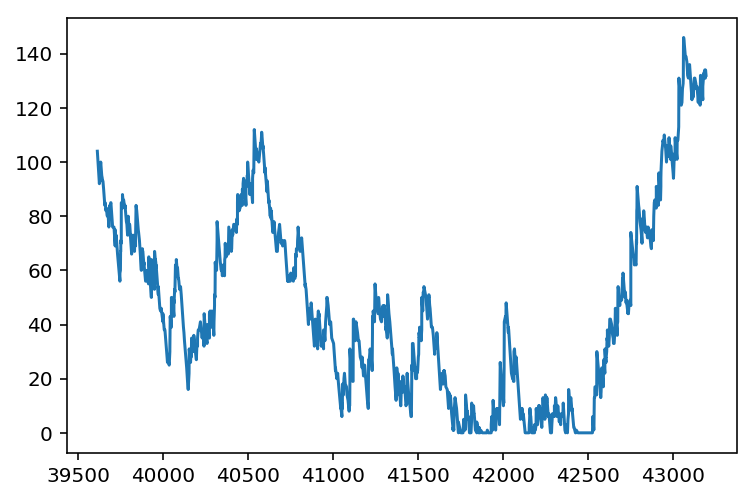

In [928]:
w_dist_start_min = 60*11
w_dist_end_min = 60*12


# wait_time_consider_ori = np.ones(np.shape(arrival_time_ori_sec))*-1
# index_within_consider = (arrival_time_ori_sec<w_dist_end_min*60)*(arrival_time_ori_sec>=w_dist_start_min*60)
# wait_time_consider_ori = wait_time_ori_sec[index_within_consider]
# wait_time_consider_ori = wait_time_consider_ori[wait_time_consider_ori > 0]


arrival_time_ori_sec
index_consider = (arrival_time_ori_sec<w_dist_end_min*60)*(arrival_time_ori_sec>=w_dist_start_min*60)
wait_time_ori_consider = wait_time_ori_sec[index_consider]
arrival_time_ori_consider = arrival_time_ori_sec[index_consider]
plt.plot(arrival_time_ori_consider,wait_time_ori_consider)

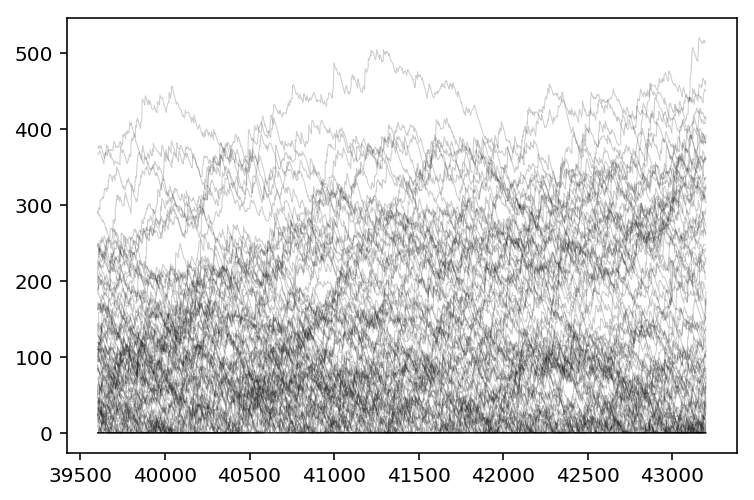

In [929]:
for i in range(n_exper):
    current_arrival_time = T_list_mat_const[i,:]*3600
    index_consider = (current_arrival_time<w_dist_end_min*60)*(current_arrival_time>=w_dist_start_min*60)
    current_arrival_time_consider = current_arrival_time[index_consider]
    current_wait_time = wait_time_const[i,:]
    current_wait_time_consider = current_wait_time[index_consider]
    plt.plot(current_arrival_time_consider,current_wait_time_consider,c='k',alpha=0.2,lw=0.5)


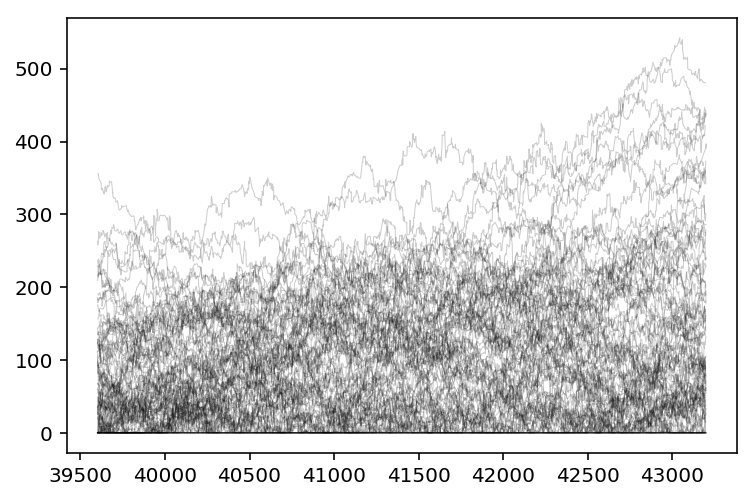

In [930]:
for i in range(n_exper):
    current_arrival_time = T_list_mat_pw[i,:]*3600
    index_consider = (current_arrival_time<w_dist_end_min*60)*(current_arrival_time>=w_dist_start_min*60)
    current_arrival_time_consider = current_arrival_time[index_consider]
    current_wait_time = wait_time_pw[i,:]
    current_wait_time_consider = current_wait_time[index_consider]
    plt.plot(current_arrival_time_consider,current_wait_time_consider,c='k',alpha=0.2,lw=0.5)

In [847]:
# wait_time_consider_pw = np.ones(np.shape(wait_time_pw))*-1
# for i in range(n_exper):
#     arrival_time_sec = (T_list_mat_const[i,:]*3600).astype(int)
#     index_within_consider = (arrival_time_sec<w_dist_end_min*60)*(arrival_time_sec>=w_dist_start_min*60)
#     n_within_consider = np.sum(index_within_consider)
#     wait_time_consider_pw[i,:n_within_consider] = wait_time_pw[i,index_within_consider]
    
# # wait_time_consider_pw = wait_time_consider_pw.flatten()
# # wait_time_consider_pw = wait_time_consider_pw[wait_time_consider_pw > 0]

In [848]:
# wait_time_consider_const = np.ones(np.shape(wait_time_const))*-1
# for i in range(n_exper):
#     arrival_time_sec = (T_list_mat_const[i,:]*3600).astype(int)
#     index_within_consider = (arrival_time_sec<w_dist_end_min*60)*(arrival_time_sec>=w_dist_start_min*60)
#     n_within_consider = np.sum(index_within_consider)
#     wait_time_consider_const[i,:n_within_consider] = wait_time_const[i,index_within_consider]
    
# # wait_time_consider_const = wait_time_consider_const.flatten()
# # wait_time_consider_const = wait_time_consider_const[wait_time_consider_const > 0]

In [849]:
# # none = plt.hist(wait_time_consider_const,bins=100,alpha=0.4)
# none = plt.hist(wait_time_consider_pw,bins=50,density=True,range=(0,200),alpha=0.2)
# none = plt.hist(wait_time_consider_const,bins=50,density=True,range=(0,200),alpha=0.2)
# plt.legend(['piecewise','const'])
# # none = plt.hist(wait_time_sec,bins=200,density=True)

In [850]:
# none = plt.hist(wait_time_consider_ori,bins=50,density=True,range=(0,200))

In [851]:
# import scipy
# scipy.stats.wasserstein_distance(wait_time_consider_ori, wait_time_consider_const)

In [852]:
# scipy.stats.wasserstein_distance(wait_time_consider_ori, wait_time_consider_pw)

ValueError: x and y must have same first dimension, but have shapes (1112,) and (673,)

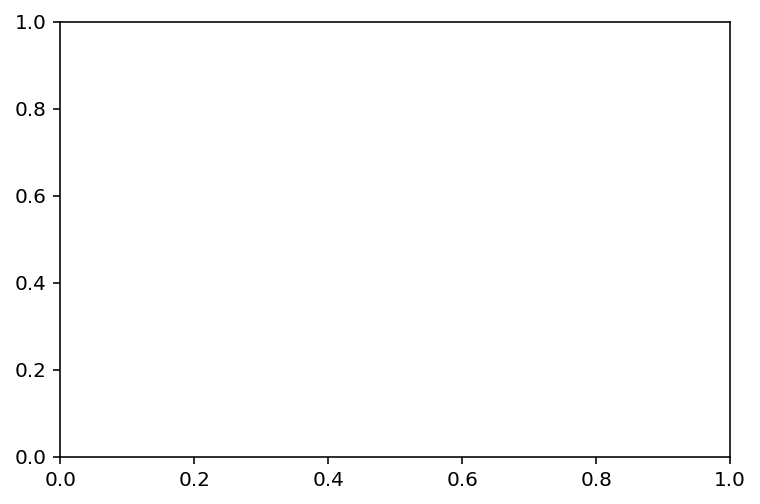

In [830]:
for i in range(n_exper):
    current = wait_time_consider_pw[i,:]
    arrival_time_sec = (T_list_mat_pw[i,:]*3600).astype(int)
    arrival_timw_consider = arrival_time_sec[(arrival_time_sec<w_dist_end_min*60)*(arrival_time_sec>=w_dist_start_min*60)]
    current = current[current > 0]
    plt.plot(arrival_timw_consider,current,c='k',alpha=0.1)

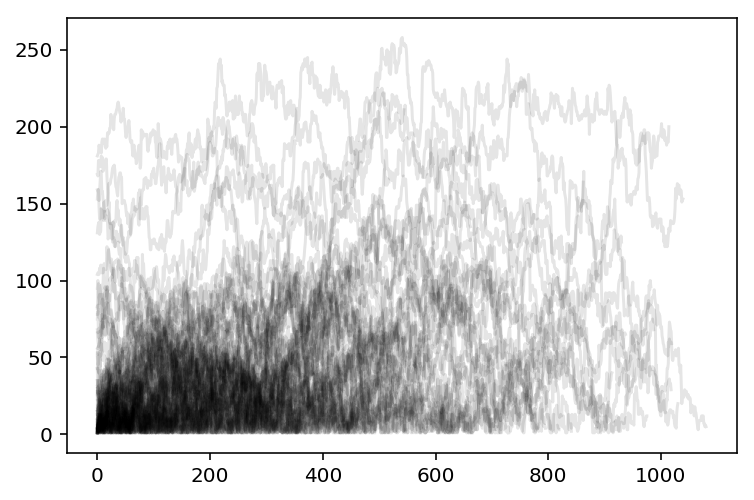

In [828]:
for i in range(n_exper):
    current = wait_time_consider_const[i,:]
    current = current[current > 0]
    plt.plot(current,c='k',alpha=0.1)

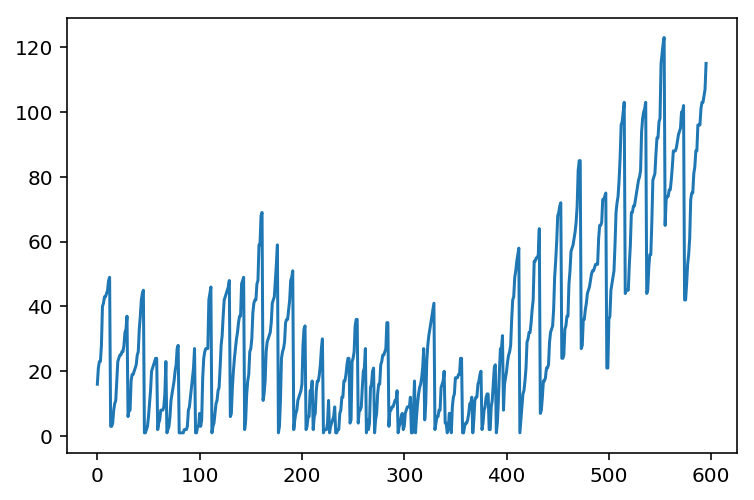

In [803]:
plt.plot(wait_time_consider_ori)

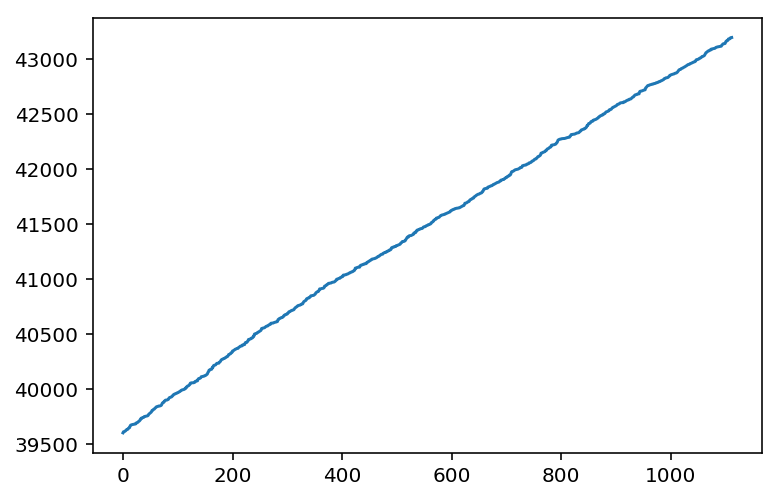

In [832]:
plt.plot(arrival_timw_consider)

KeyboardInterrupt: 

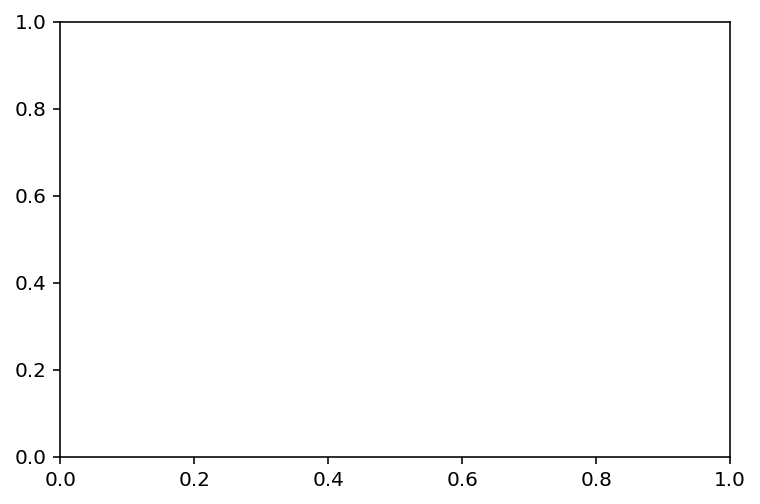

In [806]:
plt.plot(wait_time_consider_const)